# Experiment


**Data selection:**

Each tested period = Each index composition from 10 years ago quarterly -> desenhos de essas janelas!
Each fold = training period (252 days behind); Test period (93)

The performance then is evaluated quarterly to avoid selection bias! Which was higly present on the studies following deepportfolios.


**Steps:**

1. Execute the market modeling step to somehow differenciate the stocks different from the market! -> First stage of non-linear projection
2. Calculate linear risk factors using PCA from the most communal stocks
    2.1 PCA
    2.2 RMF (FIX THIS)
3. For each significant identified factor (including the one associated with the market), ammend its returns as an arbritary form to explore for arbritage opportunities
    3.1 mode one: Same as the article, arbritage opportunities in shocks! (negative correlation)
    3.2 mode two: diluted returns! a modification from the original article
4. Apply calibration step  for the factors! and see if such factors are beaten somehow!
    4.1 we might coin this new findings to a new non-linear factor capable of surpass in both modes
5. Compare wether this methodology improves over the benchmark factors



**Initial observations**:

1. When the factor is represented with positive and negative loads (long-short representation) the network lacks capabilities to deal with that, even posible negative correlated stocks are involved!
2. Long portfolios are well represented, although results are pending to see if there was any imprvements
3. The networks, in portfolio (calibration stage)
4. From few sample observations, results are not as promising as the other studies considering the other studies fell in seelction bias for the indexes they tested, which could lead to overestimate returns!



**COnsiderations:**

1. Experiments with index ongoing! to test selection bias in index

**Doubts:**

1. Autoencodeers from a financial point of view, represent more component besides the trend, seasonal, and so on?


Boa referencia de autoencoder y un párrafo para evitar describir autoencoders! seguine autoencoder siguiendo las mejores p'racticas


In [4]:
import copy
import datetime
import os

import pandas as pd
import numpy as np
 
import src.utils.returns_preprocessing as preproc
import src.pca.eigen_portfolios_functions as eg_functions

import src.autoencoders.autoencoder_market_projection as ae_market
import src.autoencoders.autoencoder_portfolio_calibration as ae_portfolio_cal

import src.utils.portfolio_utils as portfolio_utils
import src.pca.rmf_filtering as rmf_filter

import src.metrics.sharpe_ratio_stats as sharpe_ratio_stats

import logging
import pickle

logging.getLogger('tensorflow').disabled = True


%load_ext autoreload
%autoreload 2

In [5]:
import tensorflow as tf
print(tf.__version__)



2.14.0


In [6]:
tf.reduce_sum(tf.random.normal([10000,10000]))

2023-10-26 09:51:02.807804: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-10-26 09:51:02.807849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-26 09:51:02.807858: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-26 09:51:02.807918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-26 09:51:02.807944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(), dtype=float32, numpy=8329.749>

## Reading the data

in this stage, I must collect other actions!!

In [7]:
# load from persisted data
index_ticker = '^BVSP'
# Transforming all pdf index to csv
base_path = './data/ibov_comp_10_anos/prices_v2/'

quarter_ibovespa_datasets, quarter_index = [], []
for filename in os.listdir(base_path):
    # check if the filename is a file (not a directory)
    if os.path.isfile(os.path.join(base_path, filename)):
        if '_ibov.csv' in filename:
            quarter_ibovespa_datasets.append(filename)

In [8]:
# test
def removing_nan_stocks(df_prices, null_treshold_head = 0.05):
    df_prices_ = df_prices.copy()
    treshold = int(df_prices.shape[0]*null_treshold_head)
    # removing older null nan
    for col in df_prices.columns:
        if df_prices[col].head(treshold).isnull().sum() >= treshold:
            df_prices_ = df_prices_.drop(col, axis = 1)
    # starting dataseet from where there are not null values
    df_prices_ = df_prices_[df_prices_.isnull().sum().max():]
    return df_prices_


month = {'jan':'01', 'abr':'04','jul':'07', 'out':'10'}
perce_not_nan = 0.75

dataframes,non_considered_dataframes = {},{}
for file_name in quarter_ibovespa_datasets:
    df_prices = pd.read_csv('./data/ibov_comp_10_anos/prices_v2/'+file_name)
    num_tickers = len(df_prices.columns)
    # removing nan
    _date = file_name[14:18] +'-' +month[file_name[10:13]]
    df_prices = removing_nan_stocks(df_prices, null_treshold_head = 0.12)
    # filtering fold with enough data
    perc_non_empty_stocks = len(df_prices.columns) / num_tickers
    if perc_non_empty_stocks >= perce_not_nan:
        dataframes[_date] = df_prices
    else:
        non_considered_dataframes[_date] = perc_non_empty_stocks
    
#df_prices = pd.read_csv('./data/ibov_comp_10_anos/prices/prices_abr_2014_ibov.csv')
#df_index = pd.read_csv('./data/ibov_comp_10_anos/prices/indexibovespa_2014-04.csv')
#df_prices = df_prices.join(df_index)
#df_prices = removing_nan_stocks(df_prices, null_treshold_head = 0.12)


In [9]:
# test data
dataframes = {key: dataframes[key] for key in ['2018-07']}
dataframes.keys()

dict_keys(['2018-07'])

-----------------------------------------|------------------------------ 
Training set:             Date: INdex Quarterly calibration     test

### Orchestrator! .....

# implem,ent weight decay!

https://stackoverflow.com/questions/60029027/decay-parameter-of-adam-optimizer-in-keras

In [104]:
#set for invoking each dataframe! pending implement defkated sharpe value!

index_ticker = '^BVSP'
def flow_orchrestrator(df_in_sample, 
                       df_out_of_sample, 
                       folds = 2, 
                      risk_free_rate = 0.04,
                      top_communal = 15,
                      bottom_communal = 0):


    # training
    df_in_simple_returns = preproc.get_simple_returns_from_prices(df_in_sample).dropna()
    df_in_log_returns = preproc.simple_to_log_returns(df_in_simple_returns)
    df_in_log_returns_without_index = df_in_log_returns.drop(index_ticker, axis = 1)

    #def train_orchestrator():
    # 1. market modeling factors -- Tune network parameters -> tanh is the best activation layer, other experiments with other activation fucntions were done, but were not 
    model, communal_assets = non_linear_factors_mapping(df_in_log_returns_without_index, epochs = 500)
    df_log_train_index_stocks, df_log_train_arbritage_stocks = selecting_tickers(df_in_log_returns_without_index, communal_assets, top_communal, bottom_communal)
    selected_communal_assets = set(df_log_train_index_stocks.columns).union(set(df_log_train_arbritage_stocks.columns))
    
    # 2. Other Risk factors from the market stocks!
    # log to simple returns
    df_train_index_stocks = preproc.log_to_simple_returns(df_log_train_index_stocks)
    linear_factors = get_linear_factors(df_train_index_stocks)
    # Filtering random factors
    e_val_min_treshold = rmf_filter.get_eigen_values_cutting_point(df_train_index_stocks, bandwidth = 0.06, plot = False)
    filtered_linear_factors =  {
        key: values
        for key, values in linear_factors.items()
        if values["eigen_value"] >= e_val_min_treshold
    }
    #plot_linear_factors(filtered_linear_factors)

    # select factors - calculate deflated sharpe value!

    # 3. calibration stage - for each factor
    #factors_to_test = filtered_linear_factors[14]['weights']
    non_linear_factors_results = {}
    for k, v in filtered_linear_factors.items():
        y_log, y_log_ammended = ammend_y_targets(df_log_train_index_stocks, v['normalized_weights'], rate_target = 0.12, ammend_shocks = False)
        train = df_log_train_index_stocks.join(df_log_train_arbritage_stocks)
        # train
        calibration_model, results = non_linear_factors_calibration(train, y_log, y_log_ammended)
        #calibration_model, results = non_linear_factors_calibration_test(train, y_log, y_log_ammended)
        non_linear_factors_results[k] = {'calibration_model': calibration_model, 'train_results': results, 'pca_normalized_weights':v['normalized_weights'], 'eigen_value':v['eigen_value']}
        # for debugging
        break
    # calculate out of samples results
    #for k, v in non_linear_factors_results.items():
    #    v['test_results'] = out_of_sample_results(df_out_of_sample, selected_communal_assets, set(df_log_train_index_stocks.columns), v) # which one would be the reference Y
    
    non_linear_factors_results['communal_assets'] = selected_communal_assets
    
    return non_linear_factors_results


In [107]:
#walk-forward
#bottom_communal = [5,10,15,20,25]
bottom_communal = [15] # pending to execute!
# add regularizarion parameter! as grid, improvement could be using bayesian optmizer
for bottom in bottom_communal:
    print('bottom:',15)
    iterations = {}
    for _date, df in dataframes.items():
        print(_date)
        df_in_sample, df_out_sample = df.head(len(df)-93), df.tail((93))
        one_iteration = flow_orchrestrator(df_in_sample, df_out_sample, folds = 2, 
                              risk_free_rate = 0.04,
                              top_communal = 15,
                              bottom_communal = bottom)
        iterations[_date] = one_iteration
        
        


bottom: 15
2018-07
7/7 [==============================] - 0s 25ms/step
portfolio_log_returns_train_hat: 0      0.004959
1     -0.000124
2     -0.002289
3      0.001222
4     -0.001538
         ...   
198   -0.007696
199   -0.005264
200    0.015416
201   -0.025503
202   -0.010170
Length: 203, dtype: float64


In [102]:
iterations['2018-07']

{10: {'calibration_model': <keras.src.engine.functional.Functional at 0x354b3fb20>,
  'train_results': {'portfolio_log_returns_pred': array([0.00369716, 0.00380766, 0.00385785, 0.00377607, 0.00384355,
          0.00383317, 0.00385749, 0.00369072, 0.00370729, 0.00396371,
          0.00376761, 0.00369751, 0.00376225, 0.00367427, 0.0036875 ,
          0.0037955 , 0.00372517, 0.00354111, 0.00377405, 0.00386322,
          0.00399816, 0.00362718, 0.00363505, 0.00377643, 0.00375187,
          0.00390089, 0.00364161, 0.00378418, 0.00320077, 0.00376856,
          0.00368464, 0.00377989, 0.00382113, 0.00374877, 0.00382924,
          0.00384331, 0.00355244, 0.00369108, 0.00373948, 0.00358295,
          0.00352967, 0.00380838, 0.00377524, 0.00368571, 0.00356948,
          0.00374711, 0.00387311, 0.00384367, 0.00387597, 0.00387013,
          0.00410318, 0.00379264, 0.00399446, 0.00387073, 0.00355911,
          0.00367749, 0.00326955, 0.00376284, 0.00383878, 0.003901  ,
          0.00391281, 0.00356

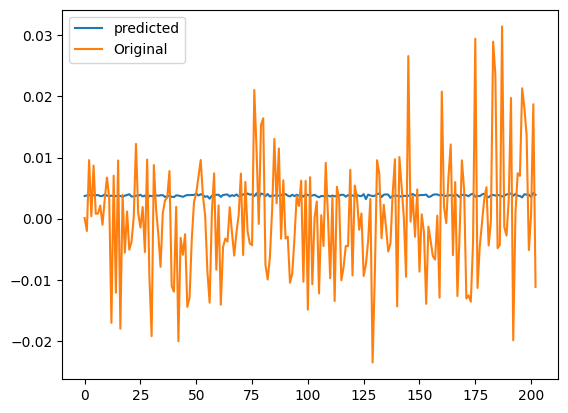

In [103]:
plot_returns(iterations['2018-07'][10])

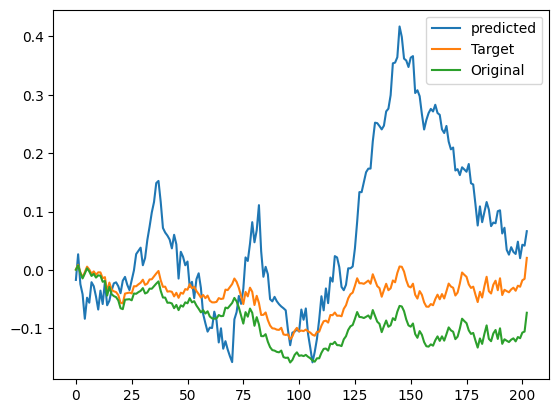

In [110]:
plot_cummulative_returns(iterations['2018-07'][13])

In [61]:
# first factor
psr_diff = []
for k,v in iterations.items():
    psr_diff.append(v[14]['test_results']['TEST_PSR'] - v[14]['test_results']['TREST_PSR_REFERENCE'])

pd.Series(psr_diff).plot.hist(label='Reasl: (PSR_pred - PSR_reference)', legend = True, bins = 15)



KeyError: 'test_results'

<AxesSubplot:ylabel='Frequency'>

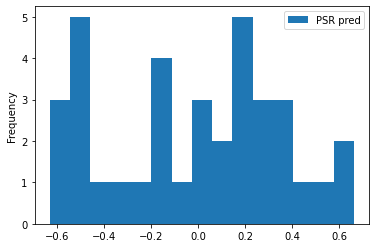

In [87]:
# second factor
psr_diff = []
for k,v in iterations.items():
    psr_diff.append(v[13]['test_results']['TEST_PSR'] - v[13]['test_results']['TREST_PSR_REFERENCE'])

pd.Series(psr_diff).plot.hist(label='PSR pred', legend = True, bins = 15)


### Methods

In [98]:
## portfolio calibration new version
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.preprocessing import StandardScaler  


my_test_models = {}
######################### TEST #################################
def non_linear_factors_calibration_test(x_train_log, y_log_train, y_log_train_amended, epochs = 100, l2_penalty = 0.01):
    
    encoder_params = {'encoding_dim': int(x_train_log.shape[1]*1.2), #change this if changes a lot
                      'optimizer':'adam', 
                      'loss':'mean_squared_error',
                      'l2_penalty': l2_penalty, 
                      'epochs': epochs, 
                      'batch_size': 64, 
                      'shuffle' : False,
                      'scale_data': True,
                      'batch_normalization': True,
                      'verbose':0}
    
    calibration_model = autoencoder_short_portfolio_calibration_fit(x_train_log, y_log_train_amended, encoder_params)
    # predict
    my_test_models['model_1'] = calibration_model
    portfolio_log_returns_train_hat = prediction_test(x_train_log, calibration_model)
    
    _psr_train = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(portfolio_log_returns_train_hat)))
    _psr_reference = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(y_log_train)))
    
    return calibration_model, {'portfolio_log_returns_pred':portfolio_log_returns_train_hat,
                   'y_log_train': y_log_train.values,
                   'y_log_ammended': y_log_train_amended.values,
                   'TRAIN_PSR_REFERENCE': _psr_reference,
                    'TRAIN_PSR': _psr_train
                 }



def autoencoder_short_portfolio_calibration_fit(x, y_target, network_params):
    
    # input autoencoder params
    encoding_dim = network_params['encoding_dim']
    l2_penalty = network_params['l2_penalty']
    optimizer =  network_params['optimizer']
    loss = network_params['loss']
    epochs = network_params['epochs']
    batch_size = network_params['batch_size']
    shuffle = network_params['shuffle'] 
    batch_normalization = network_params['batch_normalization']

    # input
    input_tensor = Input(shape=(x.shape[1],))
    # layer 2
    layer_2 = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_penalty))(input_tensor)
    if batch_normalization:    
        layer_2 = BatchNormalization()(layer_2)
    # layer 3
    layer_3 = Dense(x.shape[1], activation= 'relu', kernel_regularizer=regularizers.l2(l2_penalty))(layer_2)
    if batch_normalization:    
        layer_3 = BatchNormalization()(layer_3)
    # output
    output = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(l2_penalty))(layer_3)
    
    deep_learner = Model(input_tensor, output)
    deep_learner.compile(optimizer=optimizer, loss=loss)
    
    ss = StandardScaler()# Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    ss.fit(x)
    x = ss.transform(x)

    def decay_schedule(epoch, lr):
        # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
        if epoch == 0:    
            lr = 0.5
        if (epoch % 20 == 0) and (epoch != 0):
            lr = lr * 0.7
        return lr
    
    lr_scheduler = LearningRateScheduler(decay_schedule)
    deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size,  callbacks=[lr_scheduler])    # fit the model
    #deep_learner.fit(x, y_target, shuffle=shuffle, epochs=epochs, batch_size = batch_size)    # fit the model

    return deep_learner



def prediction_test(x, model):
    returns = model.predict(np.array(x))
    returns = returns.reshape(1, returns.shape[0])[0]
    return returns


In [106]:
def non_linear_factors_calibration(train, y_log_train, y_log_train_amended, epochs = 100, l2_penalty = 0.01):
    encoder_params = {'encoding_dim': int(train.shape[1]*0.95), #change this if changes a lot
                      'optimizer':'adam', 
                      'loss':'mean_squared_error',
                      'l2_penalty': l2_penalty, 
                      'epochs': epochs, 
                      'batch_size': 64, 
                      'shuffle' : False,
                      'scale_data': True,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'softmax',
                      'batch_normalization': True,
                      'verbose':0,
                     'custom_loss_function' : ae_portfolio_cal.custom_matmult_rmse_loss}
    
    calibration_model = ae_portfolio_cal.autoencoder_portfolio_calibration_fit(train, y_log_train_amended, encoder_params)
    # predict
    portfolio_log_returns_train_hat, weights = ae_portfolio_cal.portfolio_returns_predict(train, calibration_model, return_log = True)
    print('portfolio_log_returns_train_hat:', portfolio_log_returns_train_hat)
    
    _psr_train = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(portfolio_log_returns_train_hat)))
    _psr_reference = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(preproc.log_to_simple_returns(y_log_train)))
    
    return calibration_model, {'portfolio_log_returns_pred':portfolio_log_returns_train_hat,
                   'y_log_train': y_log_train.values,
                   'y_log_ammended': y_log_train_amended.values,
                  'weights': weights,
                    'TRAIN_PSR_REFERENCE': _psr_reference,
                    'TRAIN_PSR': _psr_train}


### NOtebook functions

In [90]:
# other methods
def plot_cummulative_returns(factor_iteration):
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['portfolio_log_returns_pred'])) + 1).cumprod() - 1).plot(label='predicted', legend = True)
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['y_log_ammended'])) + 1).cumprod() - 1).plot(label='Target', legend = True)
    ((pd.Series(preproc.log_to_simple_returns(factor_iteration['train_results']['y_log_train'])) + 1).cumprod() -1).plot(label='Original', legend = True)

# other methods
def plot_cummulative_test_returns(factor_iteration):
    ((pd.Series((factor_iteration['test_results']['y_predicted'].values)) + 1).cumprod() - 1).plot(label='predicted', legend = True)
    ((pd.Series((factor_iteration['test_results']['y_target'].values)) + 1).cumprod() -1).plot(label='Original', legend = True)


def plot_returns(factor_iteration):
    pd.Series((factor_iteration['train_results']['portfolio_log_returns_pred'])).plot(label='predicted', legend = True)
    pd.Series((factor_iteration['train_results']['y_log_ammended'])).plot(label='Original', legend = True)

def plot_linear_factors(factors):
    for k,v in factors.items():
        portfolio_utils.plot_portfolio_performance(
            v['cumulative_returns'], 
            v['weights'], 
            df_train_index_stocks.columns, 
            'Portfolio with eVal {}'.format(v['eigen_value']))

## experiment methods
# PCA
def get_linear_factors(train, denoise = False, plot_optimization = False):
    eigen_portfolios = eg_functions.get_eigenvalues_and_eigenvectors(train, is_cov = False)
    portfolios_cache = {}
    i = 0
    for eig_portfolio in eigen_portfolios:
        cumulative_returns = portfolio_utils.get_cummulative_returns(train, eig_portfolio['normalized_weights'])
        portfolios_cache[i] = {'normalized_weights':eig_portfolio['normalized_weights'] , 
                               'eigen_value': eig_portfolio['eigen_value'],
                               'eigen_vector': eig_portfolio['eigen_vector'],
                               'cumulative_returns': cumulative_returns}
        i += 1
    return portfolios_cache



def non_linear_factors_mapping(train, epochs = 100, l2_penalty = 0.01):
    # fit market representation
    encoder_params = {'encoding_dim': 5,
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': l2_penalty, 
                      'epochs': epochs, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': False,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence -> after many tests, tanh is the best  
                      'verbose':0,
                      'batch_normalization': False}
    model = ae_market.autoencoder_market_projection_fit(train, encoder_params)
    # calculating most communal assets
    communal_assets = ae_market.communal_information(train, model) # test or train??
    #results
    return model, communal_assets

def selecting_tickers(df_returns, communal_assets, n_top = 15, n_bottom = 20):
    index_associated_stocks = communal_assets.head(n_top)['ticker']
    arbritage_stocks = communal_assets.tail(n_bottom)['ticker']
    return df_returns[index_associated_stocks], df_returns[arbritage_stocks]



def ammend_y_targets(df_portfolio, linear_factor_weights, rate_target = 0.01, ammend_shocks = False):
    # return
    y_log_train = portfolio_utils.get_portfolio_returns(df_portfolio, linear_factor_weights, is_log = True)
    # ammend targets
    if ammend_shocks:
        y_log_ammended = preproc.set_target_returns_extreme_effects_by_percentile(y_log_train, .01, rate_target , 1)
    else:
        y_log_ammended = preproc.set_target_spreaded_rate(y_log_train, rate_target)
    
    return y_log_train, y_log_ammended
    

def out_of_sample_results(df_out_of_sample, communal_assets, index_communal_assets, results_data):
    # process df
    df_out_of_simple_returns = preproc.get_simple_returns_from_prices(df_out_of_sample[[communal_assets]]).dropna()
    df_out_of_log_returns = preproc.simple_to_log_returns(df_out_of_simple_returns)
    
    portfolios_log_test_returns, _ = ae_portfolio_cal.portfolio_returns_predict(df_out_of_log_returns, results_data['calibration_model'], return_log = True)
    portfolios_simple_test_returns = preproc.log_to_simple_returns(portfolios_log_test_returns)
    
    y_target = portfolio_utils.get_portfolio_returns(df_out_of_simple_returns[[index_communal_assets]], results_data['pca_normalized_weights'], is_log=False) 
        
    # rmse 
    #portfolios_test_returns - y_target
    # PSR
    _psr = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(portfolios_simple_test_returns))
    _psr_reference = sharpe_ratio_stats.probabilistic_sharpe_ratio(pd.Series(y_target))
    #Deflated_sharpe_value
    
    return {'y_target': y_target,
            'y_predicted': portfolios_simple_test_returns,
            'TEST_PSR': _psr,
           'TREST_PSR_REFERENCE': _psr_reference}
    